---
title: 1D Diffusion
date: 2023-02-21
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - MEOM Lab
    roles:
      - Primary Programmer
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: PDE, ODE, TimeStepper, Diffrax
---

* Jax-ify
* Don't Reinvent the Wheel

In [2]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import numba as nb
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 1D Diffusion scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &= \nu\frac{\partial^2 u}{\partial x^2}
\end{aligned}
$$ (eq:2dnadvection)


Here, we are advised to a 2nd order accurate central difference scheme in space and 1st order temporal scheme (Euler).

## Domain

In [3]:
nx = 41
xmin = 0.0
xmax = 2.0

In [4]:
domain = Domain.from_numpoints(xmin=(xmin,), xmax=(xmax,), N=(nx,))

print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (41,)
nDims: 1
Grid Size: (41, 1)
Cell Volume: 0.05


### Initial Conditions

$$
\begin{aligned}
\mathcal{IC}[u] &=
\begin{cases}
2 && \text{for }x \in (0.5, 1) \\
1 && \text{everywhere else}
\end{cases}
\end{aligned}
$$

In [5]:
def init_u0(domain):
    """Initial condition from grid"""
    u = jnp.ones_like(domain.grid, dtype=jnp.float64)
    u = u.at[int(0.5 / domain.dx[0]) : int(1 / domain.dx[0] + 1)].set(2.0)
    return u

In [6]:
u_init = init_u0(domain)

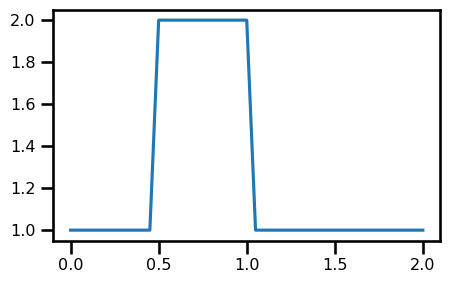

In [7]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(domain.grid.squeeze(), u_init)

plt.show()

### Equation of Motion

Because we are doing diffusion, we will use 2nd order central difference method for the terms.

$$
\begin{aligned}
D_x[u] &:= \frac{\partial^2 u}{\partial x^2}
\end{aligned}
$$ (eq:2dnadvection)

where $D$ is the central finite difference method.

In [8]:
from typing import Optional


class Diffusion1D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, u: Array, args):
        # FD - u vector
        d2u_dx2 = fdx.difference(
            u,
            axis=0,
            step_size=(domain.dx[0]),
            accuracy=1,
            derivative=2,
            method="central",
        )

        return nu * d2u_dx2

In [9]:
# SPATIAL DISCRETIZATION
u_init = init_u0(domain)

nu = 0.3

out = Diffusion1D.equation_of_motion(0, u_init, nu)


out.min(), out.max()

(Array(-120., dtype=float64), Array(120., dtype=float64))

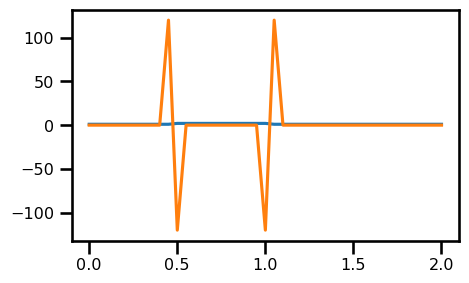

In [10]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(domain.grid.squeeze(), u_init)
ax.plot(domain.grid.squeeze(), out)
plt.show()

## Time Stepping

In [11]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain
tmin = 0.0
tmax = 0.3
num_save = 50

#### CFD Condition

In [12]:
# temporal parameters
c = 1.0
sigma = 0.2
nu = 0.3
dt = sigma * domain.dx[0] ** 2 / nu

In [13]:
# SPATIAL DISCRETIZATION
u_init = init_u0(domain)

nu = 0.3

t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)

ts = jnp.linspace(tmin, tmax, num_save)

saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = Diffusion1D(t_domain=t_domain, saveat=saveat)


# integration
u_sol = dyn_model.integrate(u_init, dt)

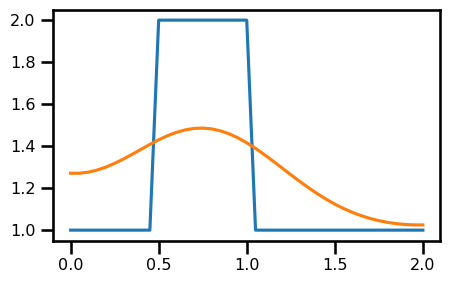

In [14]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(domain.grid.squeeze(), u_init)
ax.plot(domain.grid.squeeze(), u_sol[-1])
plt.show()

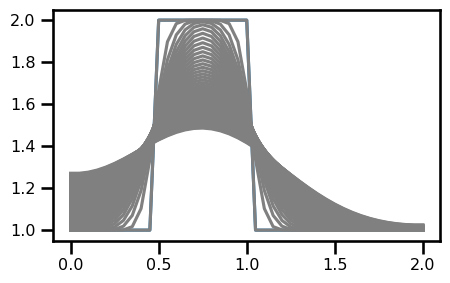

In [15]:
fig, ax = plt.subplots(figsize=(5, 3))

ax.plot(domain.grid.squeeze(), u_init)
ax.plot(domain.grid.squeeze(), u_sol.squeeze().T, color="gray")
plt.show()

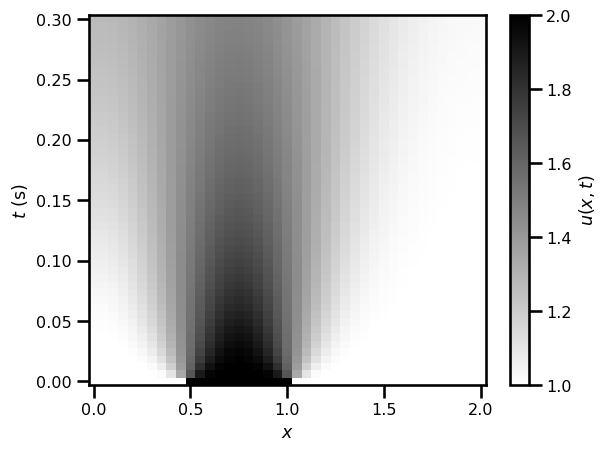

In [16]:
X, Y = np.meshgrid(domain.grid, ts)

fig, ax = plt.subplots()

pts = ax.pcolormesh(X, Y, u_sol.squeeze(), cmap="gray_r")
plt.colorbar(pts, label=r"$u(x,t)$")
ax.set(xlabel=r"$x$", ylabel=r"$t$ (s)")

plt.show()